# Detectron2

Modified From Detectron2 Official Colab Notebook Tutorial https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5

# Install Dependencies

In [1]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

     |████████████████████████████████| 276kB 7.9MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44074 sha256=281627734eba25959689dd523951b9c693296cd7f6bbb5956f505573b15d1d14
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.8.1+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
     |████████████████████████████████| 6.2MB 5.4MB/s 
     |████████████████████████████████| 51kB 9.1MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210317-cp37-none-any.whl size=58543 sha256=46faa3c34284583bd33b5169ea86c14b20f7ed92d87381fa7fda63aeeabec895
  Stored in directory: /root/.cache/pip/wheels/d2/ee/3a/5c531df777c03d8c67f22c65f97d6f75321087482d05a9b218
Successfully built fvcore


# Import Library

In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import pandas as pd
import os, json, cv2, random, itertools, uuid
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode

# Mount Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive',True)

Mounted at /content/drive


In [5]:
from distutils.dir_util import copy_tree
copy_tree('/content/drive/My Drive/detectron2/', '/content/fish_eye/')
# copy_tree('/content/drive/My Drive/detectron2_output/', '/content/my_trained')
# copy_tree('/content/drive/My Drive/datasets/fish_dataset/eye_for_detectron_inference/', '/content/resized_eye/')

['/content/fish_eye/test_eye_labels.csv',
 '/content/fish_eye/train/IMG_20210213_141951 resized.jpg',
 '/content/fish_eye/train/20210213_143139 resized.jpg',
 '/content/fish_eye/train/IMG_20210126_120404 resized.jpg',
 '/content/fish_eye/train/IMG_20210126_113210 resized.jpg',
 '/content/fish_eye/train/20210213_143054 resized.jpg',
 '/content/fish_eye/train/20210213_141437 resized.jpg',
 '/content/fish_eye/train/20210213_141444 resized.jpg',
 '/content/fish_eye/train/20210126_141114 resized.jpg',
 '/content/fish_eye/train/IMG_20210126_120455 resized.jpg',
 '/content/fish_eye/train/IMG_20210126_135446_1 resized.jpg',
 '/content/fish_eye/train/IMG_20210126_135438 resized.jpg',
 '/content/fish_eye/train/20210213_143041 resized.jpg',
 '/content/fish_eye/train/IMG_20210126_135517 resized.jpg',
 '/content/fish_eye/train/20210126_141028 resized.jpg',
 '/content/fish_eye/train/IMG_20210213_142022 resized.jpg',
 '/content/fish_eye/train/IMG_20210213_141945 resized.jpg',
 '/content/fish_eye/trai

# Convert To Dataset Catalog

In [6]:
# write a function that loads the dataset into detectron2's standard format
def get_fish_eye_dicts(csv_file, img_dir):
    df = pd.read_csv(csv_file)
    df['filename'] = df['filename'].map(lambda x: img_dir+x)

    classes = ['bandeng_eye', 'gurame_eye', 'kerapu_eye', 'nila_eye']

    df['class_int'] = df['class'].map(lambda x: classes.index(x))

    dataset_dicts = []
    for filename in df['filename'].unique().tolist():
        record = {}
        
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["height"] = height
        record["width"] = width

        objs = []
        for index, row in df[(df['filename']==filename)].iterrows():
          obj= {
              'bbox': [row['xmin'], row['ymin'], row['xmax'], row['ymax']],
              'bbox_mode': BoxMode.XYXY_ABS,
              'category_id': row['class_int'],
              "iscrowd": 0
          }
          objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [7]:
from detectron2.data import DatasetCatalog, MetadataCatalog

classes = ['bandeng_eye', 'gurame_eye', 'kerapu_eye', 'nila_eye']

for d in ["train", "test"]:
  DatasetCatalog.register('fish/' + d, lambda d=d: get_fish_eye_dicts('fish_eye/' + d + '_eye_labels.csv', 'fish_eye/' + d+'/'))
  MetadataCatalog.get('fish/' + d).set(thing_classes=classes)
fish_eye_metadata = MetadataCatalog.get('fish/train')

# Verify Dataset

In [8]:
from detectron2.utils.visualizer import Visualizer

dataset_dicts = DatasetCatalog.get('fish/train')
for d in random.sample(dataset_dicts, 10):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=fish_eye_metadata, scale=1)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Training New Model

In [9]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ('fish/train',)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[05/15 17:39:57 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f6e8b1.pkl: 243MB [00:04, 50.6MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.


[05/15 17:40:04 d2.engine.train_loop]: Starting training from iteration 0
[05/15 17:40:14 d2.utils.events]:  eta: 0:07:12  iter: 19  total_loss: 1.002  loss_cls: 0.8313  loss_box_reg: 0.05745  loss_rpn_cls: 0.05629  loss_rpn_loc: 0.009649  time: 0.4458  data_time: 0.0163  lr: 0.00039962  max_mem: 2557M
[05/15 17:40:23 d2.utils.events]:  eta: 0:07:02  iter: 39  total_loss: 0.3935  loss_cls: 0.1673  loss_box_reg: 0.1989  loss_rpn_cls: 0.007316  loss_rpn_loc: 0.004622  time: 0.4396  data_time: 0.0066  lr: 0.00079922  max_mem: 2557M
[05/15 17:40:32 d2.utils.events]:  eta: 0:06:56  iter: 59  total_loss: 0.3766  loss_cls: 0.147  loss_box_reg: 0.2275  loss_rpn_cls: 0.003095  loss_rpn_loc: 0.002703  time: 0.4445  data_time: 0.0057  lr: 0.0011988  max_mem: 2557M
[05/15 17:40:40 d2.utils.events]:  eta: 0:06:46  iter: 79  total_loss: 0.3168  loss_cls: 0.1154  loss_box_reg: 0.1931  loss_rpn_cls: 0.0003257  loss_rpn_loc: 0.002916  time: 0.4422  data_time: 0.0055  lr: 0.0015984  max_mem: 2557M
[05/1

In [10]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8
cfg.DATASETS.TEST = ('fish/test', )
predictor = DefaultPredictor(cfg)

# Load Existing Model From Drive

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file('COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml'))
cfg.DATASETS.TRAIN = ('fish/train',)
cfg.DATASETS.TEST = ('fish/test',)
cfg.MODEL.WEIGHTS = '/content/my_trained/model_final.pth'
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)

# Skip This Cell

In [ ]:
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8   # set the testing threshold for this model
cfg.DATASETS.TEST = ('fish/test', )
predictor = DefaultPredictor(cfg)

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.


# Test Set

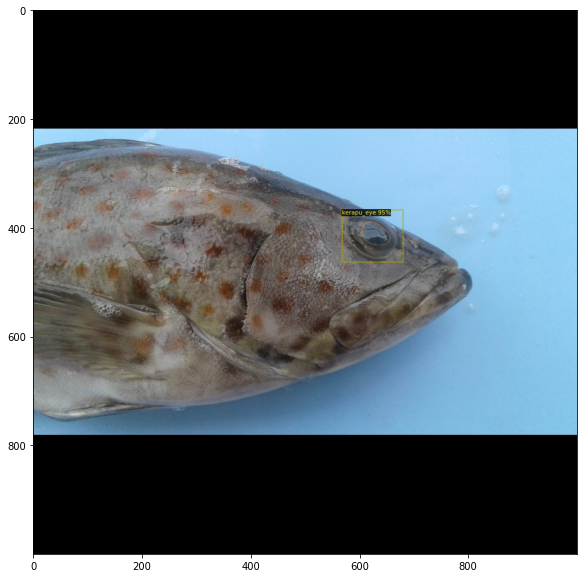

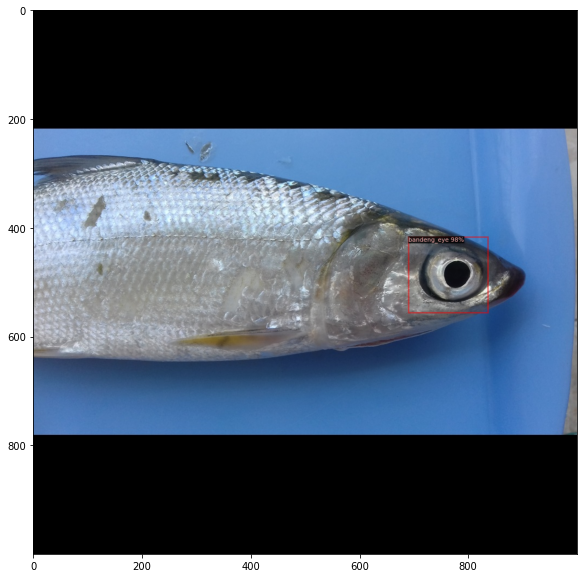

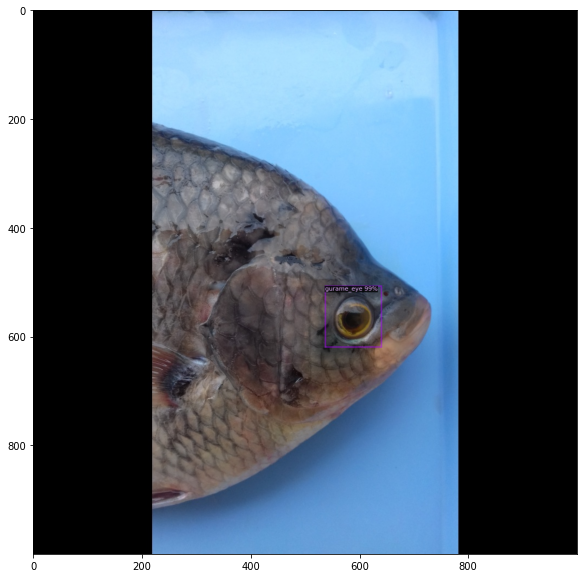

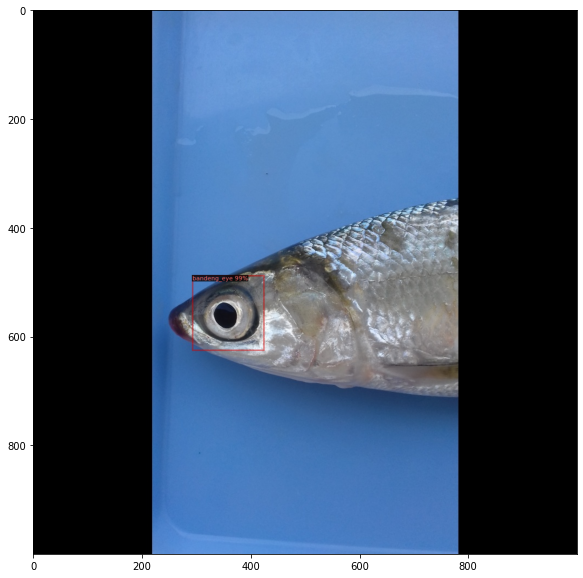

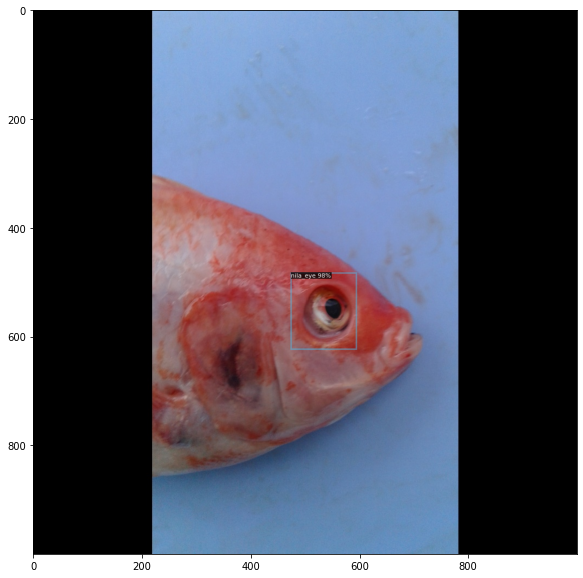

In [ ]:
dataset_dicts = DatasetCatalog.get('fish/test')
for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=fish_eye_metadata, scale=1)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

# Play With The Outputs

In [11]:
def resizeAndPad(img, size, padColor=0):

    h, w = img.shape[:2]
    sh, sw = size

    # interpolation method
    if h > sh or w > sw: # shrinking image
        interp = cv2.INTER_AREA
    else: # stretching image
        interp = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect = w/h  # if on Python 2, you might need to cast as a float: float(w)/h

    # compute scaling and pad sizing
    if aspect > 1: # horizontal image
        new_w = sw
        new_h = np.round(new_w/aspect).astype(int)
        pad_vert = (sh-new_h)/2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0
    elif aspect < 1: # vertical image
        new_h = sh
        new_w = np.round(new_h*aspect).astype(int)
        pad_horz = (sw-new_w)/2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0
    else: # square image
        new_h, new_w = sh, sw
        pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0

    # set pad color
    if len(img.shape) == 3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided
        padColor = [padColor]*3

    # scale and pad
    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=padColor)

    return scaled_img

In [12]:
width = 1000
height = 1000

crop_eye_width = 200
crop_eye_height = 200

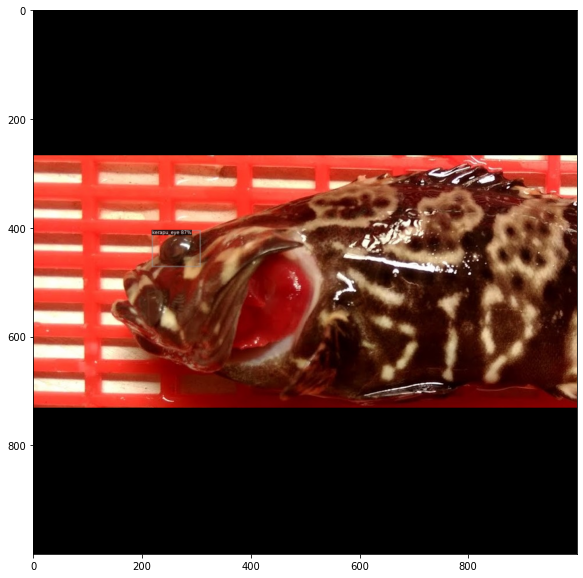

In [28]:
im = cv2.imread('IMG_20180728_102136_Copy.jpg')

# IMG20210402150059.jpg
# gurame downloaded 3.jpg
# IMG_20210123_172946.jpg
# IMG20210131115938.jpg
# IMG_20210131_172512.jpg
# IMG_20210131_162923.jpg
# IMG_20210203_124643.jpg
# IMG_20210203_131009.jpg
# IMG_20210213_141945.jpg
img = resizeAndPad(im, (width, height), 0)
outputs = predictor(img)
v = Visualizer(img[:, :, ::-1], metadata=fish_eye_metadata, scale=1)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()

# dataset_dicts = DatasetCatalog.get('microcontroller/test')
# for d in random.sample(dataset_dicts, 5):    
#     im = cv2.imread(d["file_name"])
#     outputs = predictor(im)
#     v = Visualizer(im[:, :, ::-1], metadata=microcontroller_metadata, scale=0.8)
#     v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
#     plt.figure(figsize = (14, 10))
#     plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
#     plt.show()

In [ ]:
boxes = {}
for coordinates in outputs["instances"].to("cpu").pred_boxes:
  coordinates_array = []
  for k in coordinates:
    coordinates_array.append(int(k))
  
  boxes[uuid.uuid4().hex[:].upper()] = coordinates_array
  for k,v in boxes.items():
    crop_img = im[v[1]:v[3], v[0]:v[2], :]
    resize = resizeAndPad(crop_img, (500,500), 0)
    kernel = np.array([[-1,-1,-1], 
                       [-1, 9,-1],
                       [-1,-1,-1]])
    sharpened = cv2.filter2D(resize, -1, kernel) 
    cv2.imwrite('crop_eye_resized_sharpened_3.jpg', sharpened)
    cv2.imwrite('crop_eye_resized_3.jpg', resize)
    plt.imshow(cv2.cvtColor(sharpened, cv2.COLOR_BGR2RGB))
    plt.show()

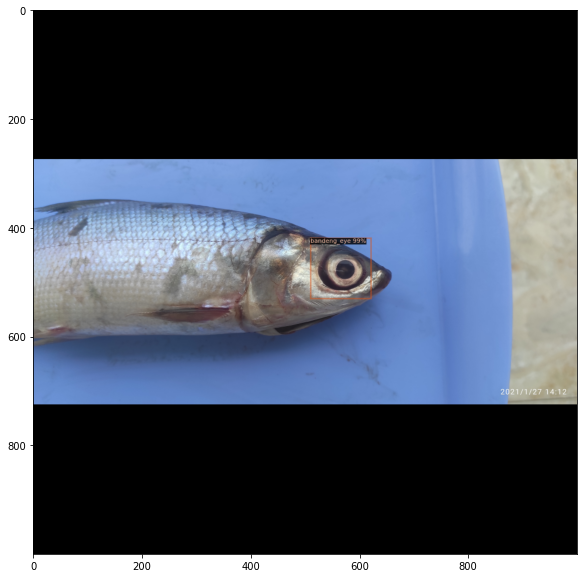

In [ ]:
im = cv2.imread('IMG_20210127_141250.jpg')

img = resizeAndPad(im, (width, height), 0)
outputs = predictor(img)
v = Visualizer(img[:, :, ::-1], metadata=fish_eye_metadata, scale=1)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()

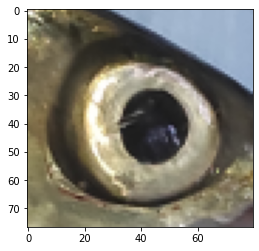

True

In [ ]:
boxes = {}
for coordinates in outputs["instances"].to("cpu").pred_boxes:
  coordinates_array = []
  for k in coordinates:
    coordinates_array.append(int(k))
  boxes[uuid.uuid4().hex[:].upper()] = coordinates_array
for k,v in boxes.items():
  crop_img = img[v[1]:v[3], v[0]:v[2], :]
  resized_img = resizeAndPad(crop_img, (crop_eye_width, crop_eye_width), 0)
  plt.imshow(cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB))
  plt.show()
  # cv2_imshow(crop_img)
  # cv2.imwrite(k + '.jpg', crop_img)

cv2.imwrite('crop_eye_bandeng4.jpg', resized_img)

# outputs['instances'].to('cpu').pred_boxes

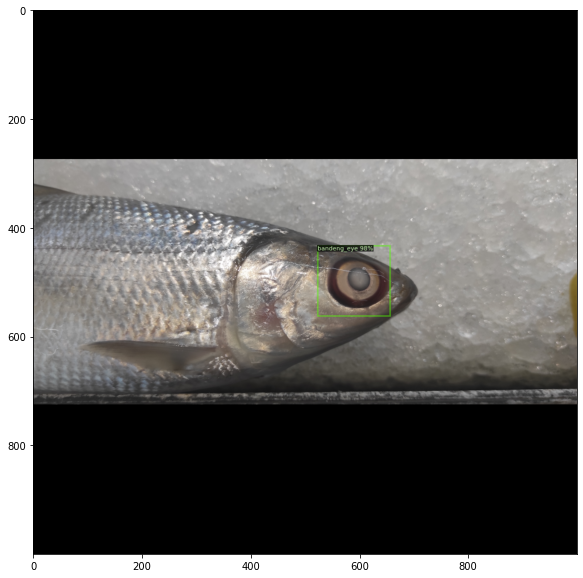

In [ ]:
im = cv2.imread('IMG_20210402_141347.jpg')

img = resizeAndPad(im, (width, height), 0)
outputs = predictor(img)
v = Visualizer(img[:, :, ::-1], metadata=fish_eye_metadata, scale=1)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()

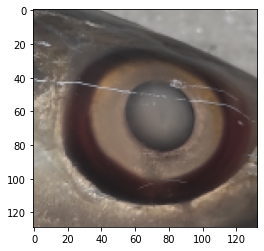

True

In [ ]:
boxes = {}
for coordinates in outputs["instances"].to("cpu").pred_boxes:
  coordinates_array = []
  for k in coordinates:
    coordinates_array.append(int(k))
  boxes[uuid.uuid4().hex[:].upper()] = coordinates_array
for k,v in boxes.items():
  crop_img = img[v[1]:v[3], v[0]:v[2], :]
  resized_img = resizeAndPad(crop_img, (crop_eye_width, crop_eye_width), 0)
  plt.imshow(cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB))
  plt.show()
  # cv2_imshow(crop_img)
  # cv2.imwrite(k + '.jpg', crop_img)

cv2.imwrite('crop_eye_bandeng4.jpg', resized_img)

# outputs['instances'].to('cpu').pred_boxes

# Modify Bounding Box Info

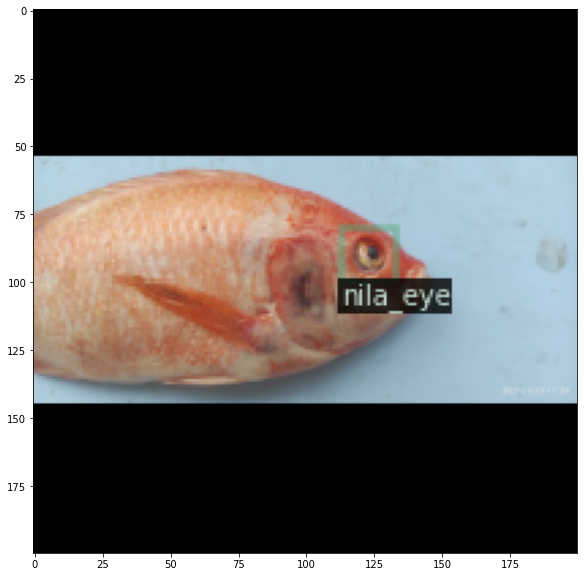

In [ ]:
bbox = outputs['instances'].pred_boxes

cls = outputs['instances'].pred_classes

obj = detectron2.structures.Instances(image_size=(200, 200))
obj.set('pred_classes', cls)
obj.set('pred_boxes', bbox)

v = Visualizer(img[:, :, ::-1], metadata=fish_eye_metadata, scale=1)
v = v.draw_instance_predictions(obj.to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()

masuk


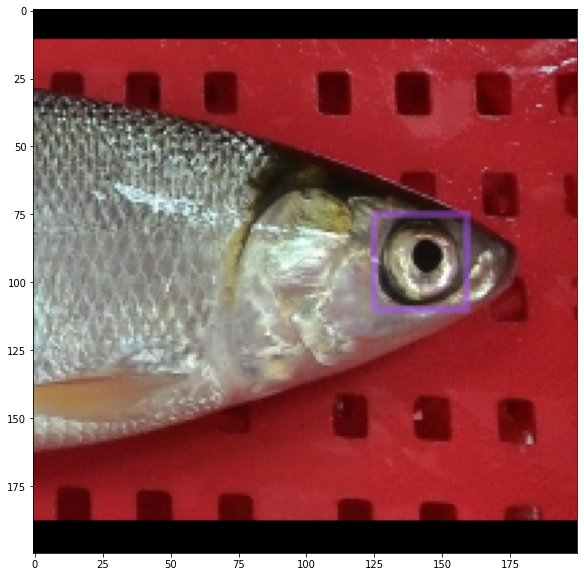

In [ ]:
# confident_detections = outputs['instances'].scores
# bbox = outputs['instances'].pred_boxes[0]
# print(bbox)
# cls = outputs['instances'].pred_classes
# print(cls)
pos = 0
for i in outputs['instances'].scores:
  if(i >= 0.9):
    print("masuk")
    bbox = outputs['instances'].pred_boxes[pos]
    # cls = outputs['instances'].pred_classes[pos]
    obj = detectron2.structures.Instances(image_size=(width, height))
    # obj.set('pred_classes', cls)
    obj.set('pred_boxes', bbox)
    break
  else:
    print("gak")
  pos += 1
# obj = detectron2.structures.Instances(image_size=(200, 200))
# obj.set('pred_classes', cls)
# obj.set('pred_boxes', bbox)

v = Visualizer(img[:, :, ::-1], metadata=fish_eye_metadata, scale=1)
v = v.draw_instance_predictions(obj.to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()

# Inference All Picture

In [ ]:
from glob import glob

for image_path in glob('/content/drive/My Drive/datasets/fish_dataset/eye_for_detectron_inference/gurame/*.*'):
  img = cv2.imread(image_path)
  outputs = predictor(img)
  v = Visualizer(img[:, :, ::-1], metadata=fish_eye_metadata, scale=1)
  v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  # print(image_path)
  image_name = image_path.split('/')
  image_name = image_name[8]
  image_name = image_name.split('.')
  image_name = image_name[0]
  print(image_name)
  image_name = '/content/cropped_eye/gurame/' + image_name + '_cropped.jpg'
  # print(image_name)
  boxes = {}
  for coordinates in outputs["instances"].to("cpu").pred_boxes:
    coordinates_array = []
    for k in coordinates:
      coordinates_array.append(int(k))
    boxes[uuid.uuid4().hex[:].upper()] = coordinates_array
  for k,v in boxes.items():
    crop_img = img[v[1]:v[3], v[0]:v[2], :]
    crop_img = resizeAndPad(crop_img, (200,200), 0)
    # plt.imshow(cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB))
    # plt.show()
    cv2.imwrite(image_name, crop_img)
    # cv2_imshow(crop_img)


# img = cv2.imread('IMG_20210127_141250.jpg')

# # img = resizeAndPad(im, (width, height), 0)
# outputs = predictor(img)
# v = Visualizer(img[:, :, ::-1], metadata=fish_eye_metadata, scale=1)
# v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# boxes = {}
# for coordinates in outputs["instances"].to("cpu").pred_boxes:
#   coordinates_array = []
#   for k in coordinates:
#     coordinates_array.append(int(k))
#   boxes[uuid.uuid4().hex[:].upper()] = coordinates_array
# for k,v in boxes.items():
#   crop_img = img[v[1]:v[3], v[0]:v[2], :]
#   plt.imshow(cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB))
#   plt.show()
#   # cv2_imshow(crop_img)
#   # cv2.imwrite(k + '.jpg', crop_img)

# cv2.imwrite('crop_eye.jpg', crop_img)

# outputs['instances'].to('cpu').pred_boxes

# plt.figure(figsize = (14, 10))
# plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
# plt.show()


20210123_162752_resized
20210123_172336_resized
20210123_172331_resized
20210123_172301_resized
20210123_173224_resized
20210123_173232_resized
20210123_172305_resized
20210123_162831_resized
20210123_162757_resized
20210123_162839_resized
20210124_143856_resized
20210124_124827_resized
20210124_143815_resized
20210124_134258_resized
20210124_124756_resized
20210124_124837_resized
20210124_134251_resized
20210124_124749_resized
20210124_123716_resized
20210124_123711_resized
20210123_224839_resized
20210123_223838_resized
20210123_224752_resized
20210123_224832_resized
20210123_224740_resized
20210123_223920_resized
20210123_223916_resized
20210123_223832_resized
20210123_204510_resized
20210123_204436_resized
20210123_204518_resized
20210123_204429_resized
20210123_203620_resized
20210123_203527_resized
20210123_193514_resized
20210123_194548_resized
20210123_194646_resized
20210123_203523_resized
20210123_194637_resized
20210123_193556_resized
20210123_194528_resized
20210123_193549_

In [ ]:
!zip -r /content/cropped_eye_lengkap.zip /content/cropped_eye

  adding: content/cropped_eye/ (stored 0%)
  adding: content/cropped_eye/nila/ (stored 0%)
  adding: content/cropped_eye/nila/20210123_224737_resized_cropped.jpg (deflated 1%)
  adding: content/cropped_eye/nila/IMG_20210123_140250_resized_cropped.jpg (deflated 2%)
  adding: content/cropped_eye/nila/20210203_164343_resized_cropped.jpg (deflated 1%)
  adding: content/cropped_eye/nila/20210124_124749_resized_cropped.jpg (deflated 2%)
  adding: content/cropped_eye/nila/20210203_131228_resized_cropped.jpg (deflated 1%)
  adding: content/cropped_eye/nila/IMG_20210124_143958_resized_cropped.jpg (deflated 2%)
  adding: content/cropped_eye/nila/20210124_134412_resized_cropped.jpg (deflated 1%)
  adding: content/cropped_eye/nila/20210123_173212_resized_cropped.jpg (deflated 2%)
  adding: content/cropped_eye/nila/20210123_224806_resized_cropped.jpg (deflated 2%)
  adding: content/cropped_eye/nila/20210123_184336_resized_cropped.jpg (deflated 2%)
  adding: content/cropped_eye/nila/20210203_144135_

In [ ]:
!rm -rf /content/cropped_eye/gurame

In [ ]:
!ls /content/cropped_eye/nila | wc -l
# !ls '/content/drive/My Drive/datasets/fish_dataset/eye_for_detectron_inference/gurame' | wc -l

212
